In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xmitgcm as xm
import pickle
import eddytools as et

#import warnings
#warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [2]:
# paths
datapath = r'D:\MITgcm_results_Leman_Sep2021\results'
gridpath = r'D:\MITgcm_results_Leman_Sep2021\results'
outputpath = 'C:\\Users\\leroquan\\Documents\\python\\eddytools\\workspace\\OW\\'

In [3]:
start_date_analysis = np.datetime64('2021-09-09T22:30:00.000000000')
end_date_analysis = np.datetime64('2021-09-10T00:30:00.000000000')

### Import OW results

In [4]:
# load velocity data
dt = 4.
data_vel = xm.open_mdsdataset(datapath, delta_t=dt,
                            ignore_unknown_vars=True, grid_dir=gridpath, 
                            geometry="cartesian", calendar="standard", ref_date="2021-07-26 0:0:0", 
                            prefix="3Dsnaps", endian='<')
data_vel = data_vel.sel(time=slice(start_date_analysis, end_date_analysis))

In [5]:
# If we already did the interpolation earlier and now start off with the interpolated fields,
# we just uncomment the line below to load them
data_OW = xr.open_dataset(outputpath + 'data_OW_std.nc').sel(time=slice(start_date_analysis, end_date_analysis))

In [6]:
data_int = xr.merge([data_vel,data_OW], compat='override').rename({"XG":"lon", "YG":"lat"})

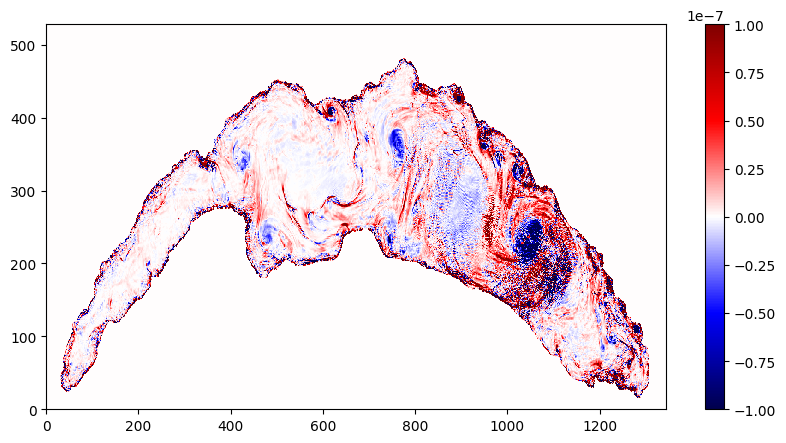

In [7]:
# Let's have a look at the fields
plt.figure(figsize=(10,5))
plt.pcolormesh(data_int['OW'].isel(time=-1), vmin= -1e-7, vmax=1e-7, cmap='seismic')
plt.colorbar()

### DETECTION

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be positive and in meters. 
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [8]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'MITgcm',
                        'grid': 'cartesian',
                        'hemi': 'north',
                        'start_time': '2021-09-09T22:30:00.000000000', # time range start
                        'end_time': '2021-09-10', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 0, # minimum longitude of detection region
                        'lon2': 65000, # maximum longitude
                        'lat1': 0, # minimum latitude
                        'lat2': 25000, # maximum latitude
                        'res': 10., # resolution of the fields in km
                        'min_dep': 250, # minimum ocean depth where to look for eddies in m
                        'OW_thr': data_int['OW_std'].values/4, # 
                        'OW_thr_name': 'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': 1, # Okubo-Weiss parameter threshold
                        'Npix_min': 1000, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 5000, # maximum number of pixels (grid cells)
                        'no_long': False, # If True, elongated shapes will not be considered
                        'no_two': False # If True, eddies with two minima in the OW
                                        # parameter and a OW > OW_thr in between  will not
                                        # be considered
                       }

Note that, when regridding was forced to be avoided in the interpolation (`avoid_regrid = True`), it will not work (yet) with `et.detection.detect_SSH`. Only detection based on the Okubo-Weiss parameter will work with the `avoid_regrid = True` option.  

### Parallel detection
There are two ways to parallelize the detection (if the necessary packages are installed.)  
   1. [**dask_bags** ](https://docs.dask.org/en/stable/bag.html). To use `dask_bags`, simply set the argument `use_bags=True` in the call to `et.detection.detect_OW()`.  
   2. [**multiprocessing**](https://docs.python.org/3/library/multiprocessing.html). To use `multiprocessing`, set argument `use_mp=True` in the call to `et.detection.detect_OW()` and specify how many CPUs to use by setting `mp_cpu=N`, with `N` being an integer.  
   
Note that `dask_bags` also uses `multiprocessing` under the hood. In most cases using `multiprocessing` directly will be faster, but tests should be conducted for each operating system and/or dataset.

In [9]:
data_int['OW_std'].values

array(-1.4089538e-09, dtype=float32)

In [10]:
# We detect eddies at a depth of 100 m
eddies = et.detection.detect_OW(data_int, detection_parameters, 'OW', 'vort', regrid_avoided=False, use_bags=False, use_mp=False)

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  3
detection at time step  2  of  3
detection at time step  3  of  3


In [11]:
from scipy import ndimage
test=ndimage.label((data_int['OW'].isel(time=1).values< data_int['OW_std'].values).astype(int))

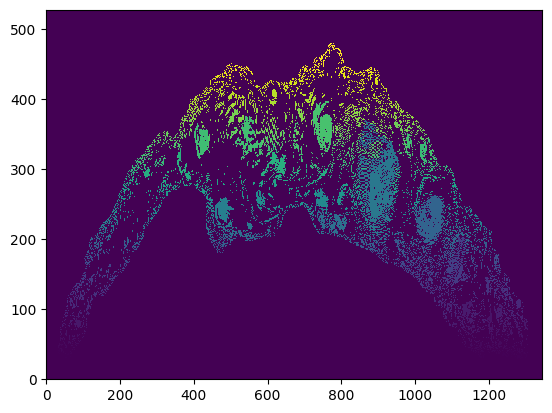

In [12]:
plt.pcolormesh(test[0])

In [13]:
# In this format, information for every detected eddy is stored
# (eddies[t][ed], where t is the time step and ed the eddy number)
eddies[2]

{0: {'time': numpy.datetime64('2021-09-10T00:30:00.000000000'),
  'lon': array([52045.75203829]),
  'lat': array([11409.54595439]),
  'amp': array([0.00057209], dtype=float32),
  'eddy_j': array([194, 194, 194, ..., 264, 264, 264], dtype=int64),
  'eddy_i': array([1030, 1031, 1034, ..., 1049, 1051, 1052], dtype=int64),
  'area': array([8.5175], dtype=float32),
  'scale': array([[1.6465735]], dtype=float32),
  'type': 'cyclonic'},
 1: {'time': numpy.datetime64('2021-09-10T00:30:00.000000000'),
  'lon': array([36909.13034452]),
  'lat': array([11935.63523731]),
  'amp': array([0.00084933], dtype=float32),
  'eddy_j': array([216, 217, 217, ..., 273, 273, 273], dtype=int64),
  'eddy_i': array([747, 747, 748, ..., 741, 742, 745], dtype=int64),
  'area': array([2.6725004], dtype=float32),
  'scale': array([[0.92232496]], dtype=float32),
  'type': 'anticyclonic'},
 2: {'time': numpy.datetime64('2021-09-10T00:30:00.000000000'),
  'lon': array([20844.53819641]),
  'lat': array([17091.25779952])

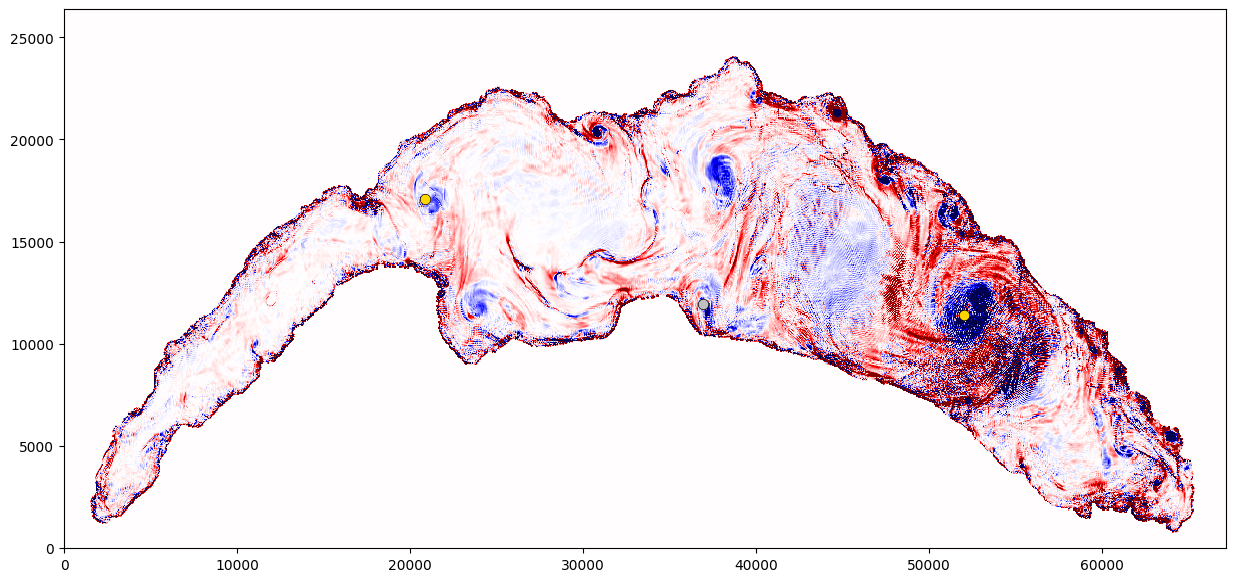

In [14]:
# Plot a single time step to see what the detection method detected
t=2
d_p = detection_parameters
plt.figure(figsize=(15,7))
plt.pcolormesh(data_int['lon'], data_int['lat'].values, data_int.OW.isel(time=t).values,
               vmin=-1e-7, vmax=1e-7, cmap='seismic')

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
    elif eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'green']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

We see that all features below a certain OW threshold have been detected. Some of them, we might not consider as an eddy. If you have the feeling, that two many features are detected, that are not eddies, change parameters like `OW_thr_factor`, `Npix_min`, `Npix_max`

In [15]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(10, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(outputpath + 'test_'
          + str(datestring) + '_eddies_OW0.3_test.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

### TRACKING

Things to note for the setting of `tracking_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the detected eddies. In our case here, for the year 0002 and a 5-day temporal resolution of the data, this is `'0002-01-05'` (The `MITgcm` stores the 5-daily averages at the end of the 5-day period).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. If you stored the detected eddies in files and want to track these, set `'dict': 0`, make sure `'data_path'`, `'file_root'` and `'file_spec'` are set accordingly and use `in_file=True` as an argument to `et.tracking.track()`.. The method will look for files `datapath + file_root + 'YYYYMMDD' + file_spec + '.pickle'`, the date `'YYYYMMDD'` is automatically calculated from `'start_time'`, `'dt'`, and `'end_time'`. You have to make sure that the stored, detected eddies contain that date in their filename (e.g. as defined in the cell above)!  

Some notes on the search distance `search_dist` that is used to determine in what radius to look for a similar eddy at the next time step.  
    - If `search_circle: True`, the algorithm simply searches for similar eddies within a radius of `search_dist` kilometers around the center of the current eddy. This is the simplest method.
    - If `search_circle: False`, the algorithm will determine where to look for similar eddies based on an ellipse with a minor axis of `search_dist` kilometers. If `search_dist: 0`, the minor and major axes of the ellipse are calculated based on the propagation of Rossby waves to account for the fact that eddies will move towards the West (see [Chelton et al., 2011](https://www.sciencedirect.com/science/article/pii/S0079661111000036) for details). In regions with strong currents this might lead to a loss of a lot of tracks, but no sensitivity studies have been conducted... 

In [32]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'MITgcm',
                       'grid': 'cartesian',
                       'start_time': '2021-09-09', # time range start
                       'end_time': '2021-09-10', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 1, # temporal resolution of the data in days
                       'lon1': 0, # minimum longitude of detection region
                       'lon2': 65000, # maximum longitude
                       'lat1': 0, # minimum latitude
                       'lat2': 25000, # maximum latitude
                       'search_dist': 10, # maximum distance of search ellipse/circle from eddy center in km
                                          # if ellipse: towards the east (if set to 0, it
                                          # will be calculated as (150. / (7. / dt)))
                       'search_circle': False, # if True, search in a circle. otherwise use ellipse
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': eddies, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath, # path to the detected eddies pickle files
                       'file_root': 'test',
                       'file_spec': 'eddies_OW0.3_test',
                       'ross_path': datapath} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [33]:
# Now we track the eddies, all information needed has to be added to `tracking_parameters`
tracks = et.tracking.track(tracking_parameters, in_file=False)

tracking at time step  2  of  2


We now have tracked all eddies that met the criteria specified in `tracking_parameters`. Every entry `i` in `tracks[i]` corresponds to one complete track.

In [34]:
# The entries in `track` look like this
tracks

[]

IndexError: list index out of range

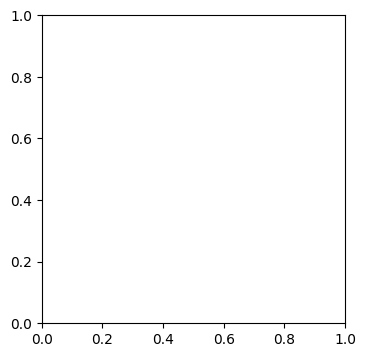

In [35]:
# To have a look at how the tracking performs, just pick an eddy and see whether it is tracked.
ed1 = 3
t = 0
j = 4

plt.figure(figsize=(18, 4))

for i in np.arange(0, j):
    plt.subplot(1, j, i + 1)
    plt.pcolormesh(data_int.lon, data_int.lat, data_int.OW.sel(time=tracks[ed1]['time'][i]).values,
                   vmin=-1e-9, vmax=1e-9, cmap=cm.balance, shading='auto')
    plt.plot(tracks[ed1]['lon'][t:t + i+1], tracks[ed1]['lat'][t:t + i+1], marker='o', color='m')

In [ ]:
# We save the tracks for later use
with open(datapath
          + 'test_00610101_00611230_tracks_OW0.3'
          + '_test.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [ ]:
# This is how to open the tracks-file again (no need to do that if we just saved it)
with open(datapath
          + 'test_00610101_00611230_tracks_OW0.3'
          + '_test.pickle', 'rb') as f:
    tracks = pickle.load(f)
f.close()

### Split up the tracking
If detecting and tracking in larger regions, the tracking can take very long. Because computations are often limited in duration on high-performance computing clusters, an option to split up the tracking into several chunks has been added. Note that the tracking still needs to be done serially, one chunk after the other.

We first track the first half of the year, using the function `split_track()`.

In [ ]:
tracking_parameters_split = tracking_parameters
tracking_parameters_split['start_time'] = '0061-01-03'
tracking_parameters_split['end_time'] =  '0061-06-30'

In [ ]:
tmp_split1, tracks_split1, terminated1 = et.tracking.split_track(tracking_parameters_split, 
                                                                 in_file=False, continuing=False)

The file `tmp_split1` contains the tracks for the first time span as if they were tracked with `track()`. `tracks_split` additionally contains all unfinished tracks and needs to be passed on to the next round of tracking. `terminated1` contains all tracks that have been already terminated and needs to passed on to the next round as well to make sure they don't get tracked again.

In [ ]:
tracking_parameters_split['start_time'] = '0061-07-03'
tracking_parameters_split['end_time'] =  '0061-12-30'

In [ ]:
tracks_from_split, tracks_split2, terminated2 = et.tracking.split_track(tracking_parameters_split, 
                                                                        in_file=False, continuing=True,
                                                                        tracks=tracks_split1,
                                                                        terminated_set=terminated1)

The variable `tracks_from_split` now contains the same tracks as the variable `tracks` from the normal tracking function `track()`. `tracks_split2` and `terminated2` are only needed when another period of tracking is to be added.

### SAMPLING

Things to note for the setting of `sample_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the tracked eddies. In our case here, for the year 0002 and a 5-day temporal resolution of the data, this is `'0002-01-05'` (The `MITgcm` stores the 5-daily averages at the end of the 5-day period).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. Right now, the usage of `'range'` and `'split'` has not been thouroughly tested! It seems to work for most cases though.  

`'range'`: Set to `True` if you only want to sample eddies within a certain range `'values_range'` of a property `'var_range'` in the dataset `'ds_range'`. `'var_range'` needs to be 2D (thus the `.isel(z=9)` in the example below) and interpolated to the same grid as `OW` used above. It is most likely that, if you follow this example, `'var_range'` is stored in the same dataset as `OW`. In the example below, only eddies that have a center temperature between 4 and 7 degrees C at depth level 10 (`z=9`) will be sampled and stored.  

`'split'`: Set to `True` if you want to split the sampled eddies into two categories, above and below a certain threshold value `'value_split'` of a variable `'var_split'` in the dataset `'ds_split'`. As for `'range'`, `'var_split'` needs to be 2D and interpolated to the same grid as `OW` used above. In the example below the eddies will be put into two categories: In the first category, the eddies must have a center salinity above 34.0 and in the second category, below 34.0.

In [ ]:
# For the sampling we again have to specify some parameters, defining when, where and which 
# eddies to sample.
# Because the dataset containing the sampled eddies can grow huge for larger regions and/or
# longer time periods, `eddytools.sample.sample()` writes the samples for each individual
# eddy to individual netcdf-files on disk!
sample_parameters = {'model': 'MITgcm',
                     'grid': 'cartesian',
                     'start_time': '0061-01-05', # time range start
                     'end_time': '0061-12-30', # time range end
                     'max_time': 146, # maximum length of tracks to consider
                                     # (model time steps)
                     'calendar': '360_day', # calendar, must be either 360_day or standard
                     'dt': 5, # temporal resolution of the data in days
                     'lon1': 0.6e6, # minimum longitude of detection region
                     'lon2': 1.3e6, # maximum longitude
                     'lat1': 1.0e6, # minimum latitude
                     'lat2': 1.3e6, # maximum latitude
                     'res': 10.,
                     'type': 'anticyclonic', # type of eddy
                     'lifetime': 5, # length of the eddy's track in days
                     'size': 25, # eddy size (radius in km)
                     'd_surr': 1, # surroundings size
                     'range': False, # sample eddy within a range of `var_range`
                     'ds_range': data_int.isel(z=9), # dataset of `var_range`
                     'var_range': ['THETA'], # variable to base the range on
                     'value_range': [[4, 7],], # range of `var_range`
                     'split': False, # split eddies at a threshold in below and above
                     'ds_split': data_int.isel(z=9), # dataset of `var_split`
                     'var_split': ['SALT'], # variable to base split on
                     'value_split': [34.0,], # split eddies at this value
                     'sample_vars': ['THETA'], # variables to sample
                     'save_location': datapath, # where to store the netcdf files 
                     'save_name': 'test'}

The sampling can take quite long as for every eddy that fits the criteria we need to read data from disk at every time step  
The names of the files will be defined by `save_name`, the criteria you specify and the eddy number  
For this sampling parameters, the file name of the first eddy will be  
`test.anticyclonic.larger_25.longer_5.0000001.nc`  

If you set `'split'` to `True`, the file names will differ for the two categories.  
`test.anticyclonic.larger_25.longer_5.0000001.above_thr.nc` for eddies that are above `'value_split'`  
`test.anticyclonic.larger_25.longer_5.0000001.below_thr.nc`
for eddies that are below `'value_split'`.

In [ ]:
et.sample.sample(tracks, data_int, sample_parameters)

# AVERAGING

We can now average over the sampled eddies.  
As each eddy has its own file, we first need to find out how many files/samples there are, so we can loop over them and then store the datasets in a dictionary.  
Note that for large region, i.e. a lot of samples the resulting dataset could be too large to fit into memory. The `chunks={}` argument to `xr.open_dataset()` is an attempt to overcome this, however I do not know yet whether this has a lot of effect! One could also split the samples into several parts and then work on each part seperately (the number of eddies going into each average is stored, so one could later do a weighted average over the different parts!)

In [ ]:
# Find out number of samples
samples = {}
num_samples = len(glob(sample_parameters['save_location']
                       + sample_parameters['save_name'] + '.anticyclonic.larger_25.longer_5.*.nc'))

In [ ]:
# Now we load each stored sample
for i in np.arange(1, num_samples + 1):
    snum = "%07d" % (i,)
    samples[i] = xr.open_dataset(sample_parameters['save_location'] + sample_parameters['save_name'] +
                                 '.anticyclonic.larger_25.longer_5.' + str(snum) + '.nc', chunks={})

First a "preparation" is performed: Basically, all eddies are interpolated onto a normalized (in length) section crossing them through the eddy center. This section's orientation can be defined by the argument `section`, which can be either `'zonal'` (default) or `'meridional'`. The length of this section can be defined with argument `interp_vec`. A larger number gives a finer resolution of the interpolated data, but might not necessarily be useful (if input data is coarser resolution for example).    
For every variable specified, at every time step, the values and anomalies (with respect to surroundings) are interpolated (with method `method`) onto the normalized section and stored according to the month the eddy was first detected. The depth profile of the surroundings is stored as well.  
For available interpolation methods please have a look in the documentation of the underlying function [`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).

In [ ]:
normalized_eddies = et.average.prepare(samples, ['THETA'], interp_vec=41, interp_method='nearest', section='meridional')

In [ ]:
normalized_eddies['THETA_anom']['12'].shape

Here for example, 12 eddies originating in December have been stored with a maximum length of 15 time steps. 55 is the length of the depth dimension, 41 the length of the normalized section.

Next we can average these samples in different ways.  
Three possibilities are given with `average`  
1. seasonal -> bins the samples (of all available years) into four seasons (DJF, MAM, JJA, SON) and averages them into a seasonal climatology  
2. monthly  -> does the same for each month (so you end up with a monthly climatology)  
3. total    -> averages over all available eddies  
The three methods all return the means, standard deviations (across eddies), and the number of eddies that went into the derived quantities for a) the variables specified, b) their anomalies to the surroundings, c) the surroundings. These results are stored in the output dictionary under `output['ave']['mean'][period]['variable']`, `output['ave']['mean'][period]['variable_anom']`, `output['ave']['mean'][period]['variable_around']`, respectively. `period` refers to 1. `DJF`, `MAM`, `JJA` or `SON`, 2. `01`, `02`, `03`, etc., representing the month, or in case of the total average thie layer in the dictionary does not exist.  
Additionally, the averaged temporal evolution of the eddy centers will be stored under `output['evo'][...]`.

In [ ]:
season_eddies = et.average.seasonal(normalized_eddies, ['THETA'])

In [ ]:
plt.pcolormesh(np.arange(0, 41), data_int.z, 
               season_eddies['ave']['mean']['MAM']['THETA_anom'], vmin=-1, vmax=1, cmap=cm.balance)
plt.colorbar()

In [ ]:
monthly_eddies = et.average.monthly(normalized_eddies, ['THETA'])

In [ ]:
plt.pcolormesh(np.arange(0, 41), data_int.z, 
               monthly_eddies['ave']['mean']['03']['THETA_anom'], vmin=-1, vmax=1, cmap=cm.balance)
plt.colorbar()

In [ ]:
total_eddies = et.average.total(normalized_eddies, ['THETA'])

In [ ]:
plt.pcolormesh(np.arange(0, 41), data_int.z, 
               total_eddies['ave']['mean']['THETA_anom'], vmin=-1, vmax=1, cmap=cm.balance)
plt.colorbar()